In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision

from unet import UNetModel
from diffusion import GaussianDiffusion

import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')

## Load Data

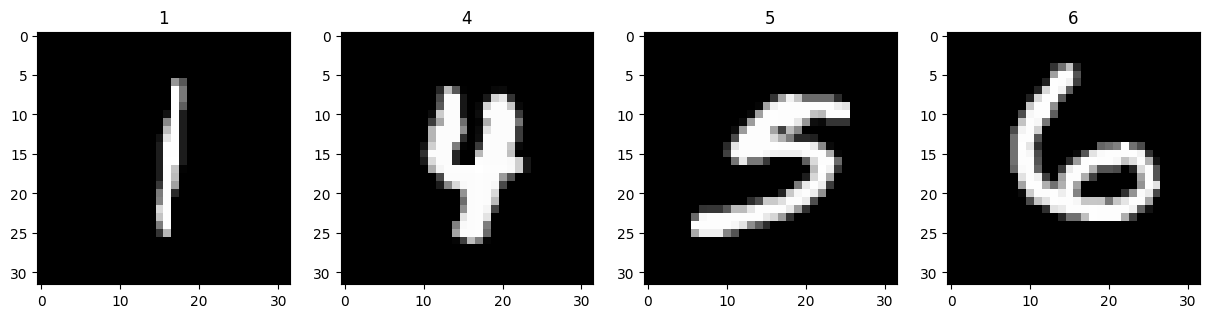

In [4]:
# Load MNIST dataset
device = torch.device('cuda:0')
batch_size = 128

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Pad(2), # Make MNIST images 32x32
    torchvision.transforms.Normalize(0.5, 0.5),
])
mnist_train = torchvision.datasets.MNIST(root='data/', train=True, transform=transforms, download=True)
data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

for batch in data_loader:
    img, labels = batch
    break
    
fig, ax = plt.subplots(1, 4, figsize=(15,15))
for i in range(4):
    ax[i].imshow(img[i,0,:,:].numpy())
    ax[i].set_title(str(labels[i].item()))
plt.show()

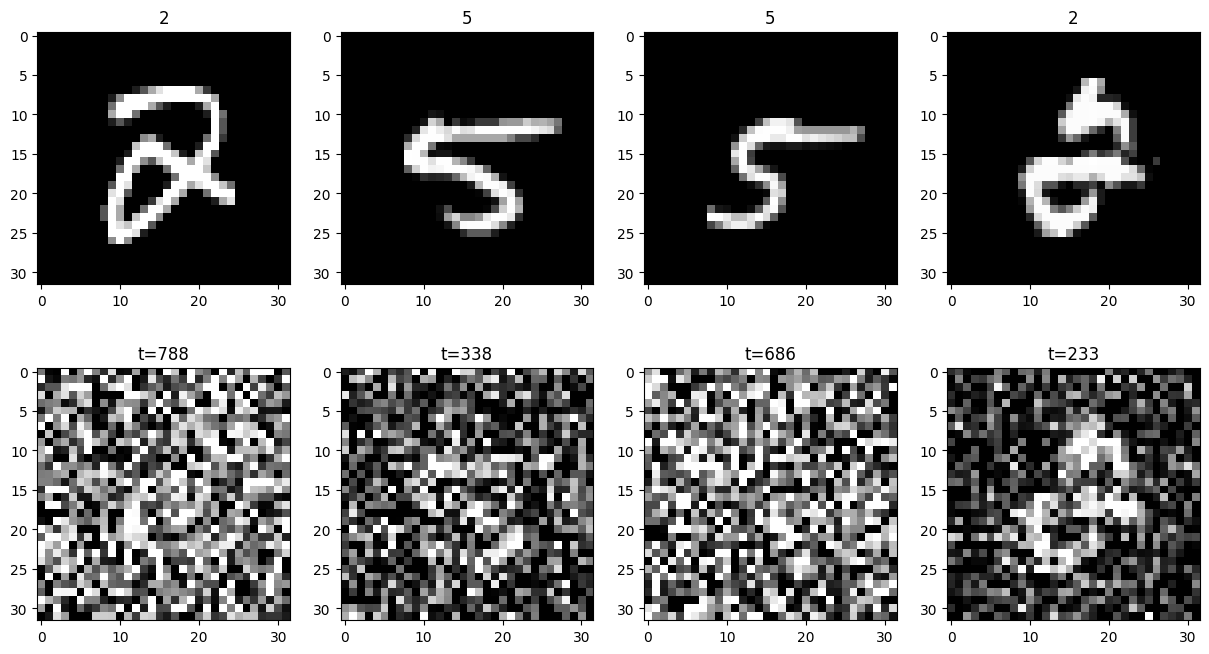

In [5]:
# Sample from diffusion process
diffusion = GaussianDiffusion(T=1000, schedule='linear')

x0, y = next(iter(data_loader))
t = np.random.randint(1, diffusion.T+1, batch_size).astype(int)
xt, _ = diffusion.sample(x0, t)

fig, ax = plt.subplots(2, 4, figsize=(15,8))
for i in range(4):
    ax[0,i].imshow(x0[i,0,:,:].numpy(), vmin=-1, vmax=1)
    ax[0,i].set_title(str(y[i].item()))
    
    ax[1,i].imshow(xt[i,0,:,:].numpy(), vmin=-1, vmax=1)
    ax[1,i].set_title(f't={t[i]}')
plt.show()

## Train Diffusion Network

Network parameters: 22078017
Epoch [1/10]


100%|██████████| 469/469 [00:58<00:00,  8.04it/s, Loss=0.0225]


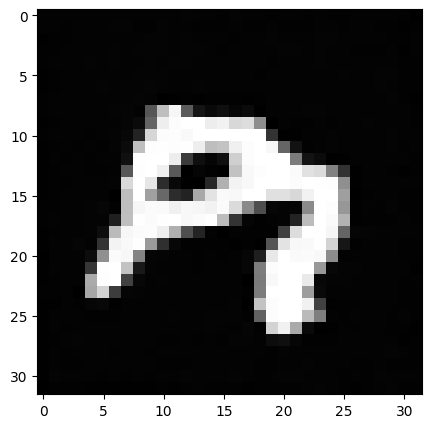

Epoch [2/10]


100%|██████████| 469/469 [00:58<00:00,  8.04it/s, Loss=0.0199]


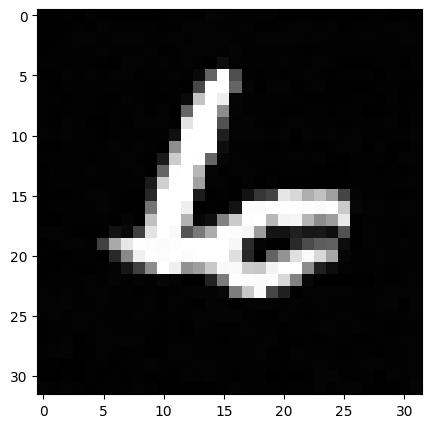

Epoch [3/10]


100%|██████████| 469/469 [00:58<00:00,  8.05it/s, Loss=0.019] 


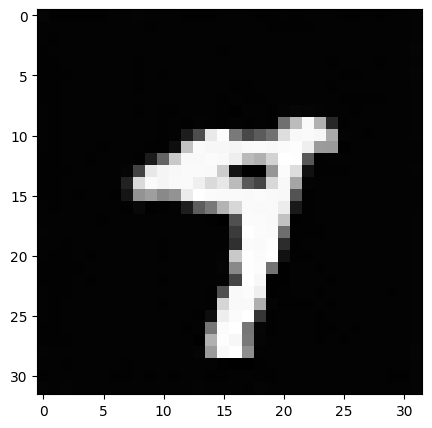

Epoch [4/10]


100%|██████████| 469/469 [00:57<00:00,  8.11it/s, Loss=0.0196]


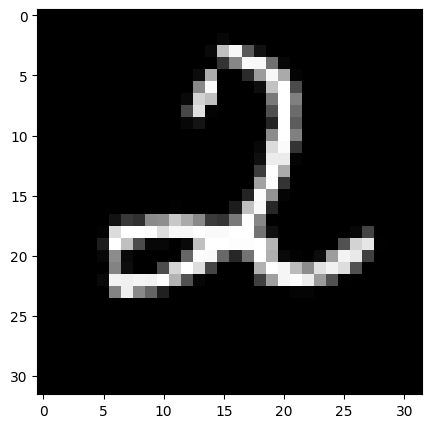

Epoch [5/10]


100%|██████████| 469/469 [00:59<00:00,  7.93it/s, Loss=0.0197]


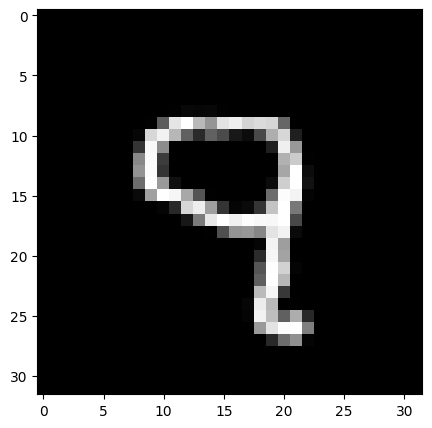

Epoch [6/10]


100%|██████████| 469/469 [01:01<00:00,  7.57it/s, Loss=0.0174]


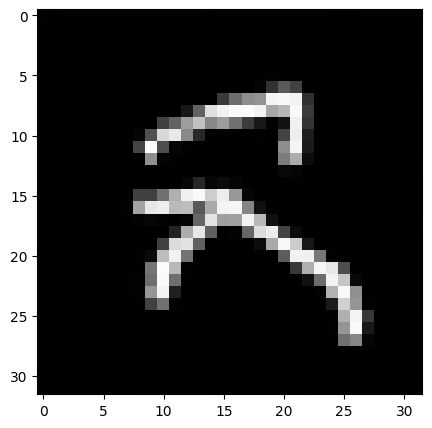

Epoch [7/10]


100%|██████████| 469/469 [01:01<00:00,  7.67it/s, Loss=0.0173]


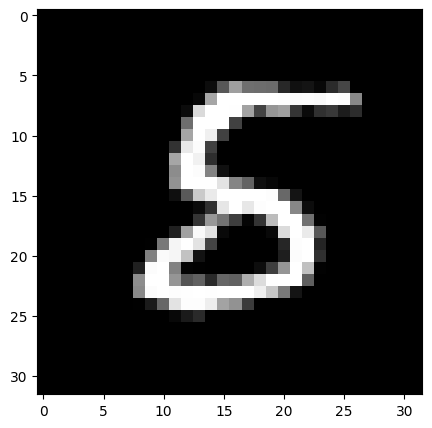

Epoch [8/10]


100%|██████████| 469/469 [00:58<00:00,  7.95it/s, Loss=0.0181]


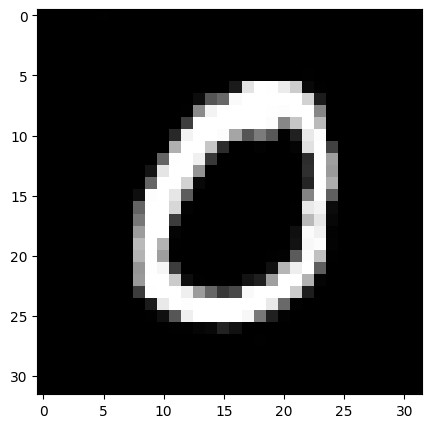

Epoch [9/10]


100%|██████████| 469/469 [00:57<00:00,  8.14it/s, Loss=0.0171]


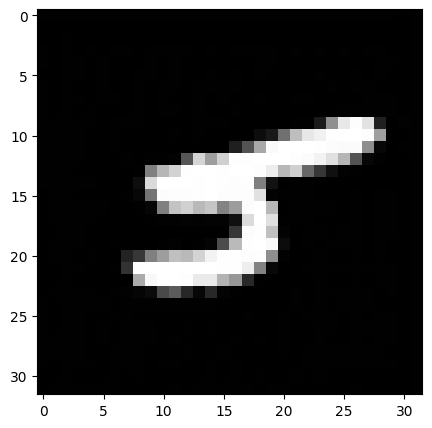

Epoch [10/10]


100%|██████████| 469/469 [00:58<00:00,  8.00it/s, Loss=0.0171]


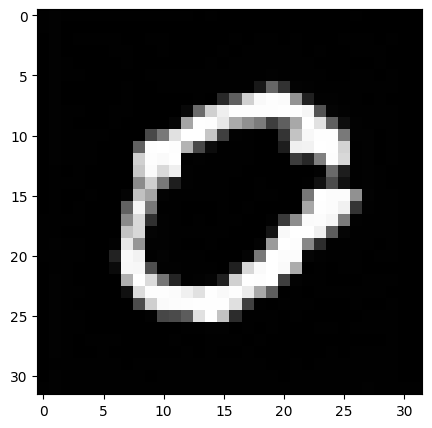

In [6]:
# Train network
net = UNetModel(image_size=32, in_channels=1, out_channels=1, 
                model_channels=64, num_res_blocks=2, channel_mult=(1,2,3,4),
                attention_resolutions=[8,4], num_heads=4).to(device)
net.train()
print('Network parameters:', sum([p.numel() for p in net.parameters()]))

opt = torch.optim.Adam(net.parameters(), lr=1e-4)

diffusion = GaussianDiffusion(T=1000, schedule='linear')

epochs = 10
update_every = 20
for e in range(epochs):
    print(f'Epoch [{e+1}/{epochs}]')
    
    losses = []
    batch_bar = tqdm.tqdm(data_loader)
    for i, batch in enumerate(batch_bar):
        img, labels = batch
        
        # Sample from the diffusion process
        t = np.random.randint(1, diffusion.T+1, img.shape[0]).astype(int)
        xt, epsilon = diffusion.sample(img, t)
        t = torch.from_numpy(t).float().view(img.shape[0])
        
        # Pass through network
        out = net(xt.float().to(device), t.to(device))

        # Compute loss and backprop
        loss = F.mse_loss(out, epsilon.float().to(device))
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        if i % update_every == 0:
            batch_bar.set_postfix({'Loss': np.mean(losses)})
            losses = []
            
    batch_bar.set_postfix({'Loss': np.mean(losses)})
    losses = []

    # Visualize sample
    with torch.no_grad():
        net.eval()
        x = diffusion.inverse(net, shape=(1,32,32), device=device)
        net.train()
    
    plt.figure(figsize=(5,5))
    plt.imshow(x.cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
    plt.show()

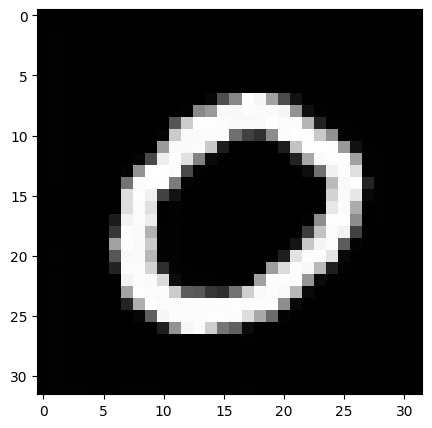

In [7]:
# Sample from the learned diffusion process
diffusion = GaussianDiffusion(T=1000, schedule='linear')

with torch.no_grad():
    net.eval()
    x = diffusion.inverse(net, shape=(1,32,32), device=device)
    net.train()

plt.figure(figsize=(5,5))
plt.imshow(x.cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
plt.show()

In [8]:
#Save/Load model
torch.save(net.state_dict(), 'models/mnist_unet.pth')
print('Saved model')

net = UNetModel(image_size=32, in_channels=1, out_channels=1, 
                model_channels=64, num_res_blocks=2, channel_mult=(1,2,3,4),
                attention_resolutions=[8,4], num_heads=4).to(device)
net.load_state_dict(torch.load('models/mnist_unet.pth'))
net.to(device)
net.train()
print('Loaded model')

Saved model
Loaded model


/tmp/ipykernel_4742/1593376403.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('models/mnist_unet.pth'))
